# Modeling Personal Loan Delinquency with LendingClub Data

The domain of our project is peer-to-peer consumer lending. Our goal is to model credit risk on personal loans, more precisely to evaluate the probability of default or delinquency of borrowers during their loan period.

LendingClub loans are made over either a 36 or 60 month term, with a variety of statistics reported about each unique loan on a monthly basis (our analysis focuses on the 36 month terms). Our variable of interest is called `loan_status` which has eight possible states. We attempt to model credit risk by estimating the probability of a loan transitioning between any two of these states at any month during the loan term. Below are the eight `loan_status` states, with descriptions from LendingClub's [website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):

- **Issued**: New loan that has passed all LendingClub reviews, received full funding, and has been issued.

- **Current**: Loan is up to date on all outstanding payments. 

- **In Grace Period**: Loan payment is late, but within the 15-day grace period.
 
- **Late (16-30)**: Loan is late, past the grace period, hasn't been current for 16 to 30 days.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days.
 
- **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments. Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off. Loans for which borrowers have filed for bankruptcy may be charged off earlier.

- **Default**: Loan has not been current for an extended period of time. Charged off and default states are similar, yet different. [TODO explain]

- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

To model the transition states month over month, we employed a stationary discrete time step Markov Chain model. Discrete because our data is on a monthly basis, and stationary because we assume the probability distribution of  transition is independent of time (we use the same model across all month). Recall the Markov property, or the "memoryless" assumption, that for some sequence of events, that the conditional probability of the next time step $x_t$ depends only upon the previous time step $x_{t-1}$, ignoring all time steps that preceded it:

$$
\begin{align*}
p(X_t = x_t | X_{t-1} = x_{t-1}, X_{t-2} = x_{t-2}, ... , X_0 = x_0) = p(X_t = x_t | X_{t-1})
\end{align*}
$$

For a discrete time Markov Chain, the joint distribution for the probability of some sequence length $T$ can then be written as:

$$
\begin{align*}
p(X_{1:T}) = p(X_1)p(X_2 | X_1) p(X_3 | X_2) ... = p(X_1)\prod_{t=2}^{T}p(X_t | X_{t-1})
\end{align*}
$$

[Murphy, 2012, p. 589](#References)

For $K$ outcome states, the conditional distribution $p(X_t | X_{t-1})$ can be written as a $K \times K$ transition matrix (denoted $A$) where $A_jk  = p(X_t = k | X_{t-1} = j)$ (the probability of transitioning from states $j$ to state $k$, where each row in the matrix can be thought of as a probability mass function). In our case $K=8$ and we have an $8 \times 8$ transition matrix. The goal of our analysis, then, is to estimate the posterior probabilities of this transition matrix using our observed data.

## Data

Our dataset consists of approximately 40 million observations from loans spanning between 2007 through Q3 2018. The dataset includes dozens of fields, however for our Markov model (and to simplify data management) we only need to work with 4 features: `id`, `loan_status`, `term`, and `age_of_loan`. During preprocessing, we also filtered out all loans with a 60 month term and 36 term loans that extended beyond 36 months, reducing our dataset to around 27 million observations. In total, we have just under 1.5 million unique loans, which can be seen in the rows column after we split and pivot our data below.

In [1]:
from utils.utils import load_dataframe, preprocess, split_data
from utils.models import build_mle_matrix, build_mc_no_priors, build_mc_with_priors
from utils.inference import compute_mle, infer_mc_no_priors, infer_mc_with_priors
from utils.criticism import sample_mle, plot_sampled_lengths
import numpy as np

In [2]:
df = load_dataframe()

Loading raw data from cache...
Retrieved 40,268,594 rows, 4 columns in 2.78 seconds


In [3]:
df = preprocess(df)

Mapping column names...
Loading preprocessed data from cache...
Retrieved 27,641,460 rows, 4 columns in 2.33 seconds


In [4]:
x_train, x_test = split_data(df)

Loading split data from cache...
Retrieved 1,486,355 rows, 36 columns in 0.43 seconds
Train: (1338437, 36) | Test: (147918, 36)


In [5]:
chain_len = max(df.age_of_loan)
n_states = df.loan_status.unique().shape[0]

## Experiment 1: Markov Model with Maximum Likelihood Estimates

### 1.1 Model

To get some intuition on how to estimate the transition matrix given our training data, $N$, we start with MLE estimation. The MLE solution of a Markov Chain is simply the empirical frequencies of each transition. Formally, the probability of some particular sequence length $T$, with transition matrix $M$ and states $K$ is given by: 

$$ 
\begin{align*}
p(x_{1:T}|\theta) = p(x_1)A(x_1, x_2)...A(x_{T-1}, x_T) 
&= \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x_1 = j)} \prod_{t=2}^{T} \prod_{j=1}^{K} \prod_{k=1}^{K}(A_{jk})^{\mathbb{I}(x_{t-1} = j, x_t = k)}
\end{align*}
$$

It is relatively easy to show that the MLEs for $p_j$ (at state $j$) and $T_{jk}$ (at transition from states $j$ to $k$) are given by the observed frequencies:  
$$ 
\begin{align*}
p_j = \frac{\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}{\sum_{j}\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}
\end{align*}
$$

$$ 
\begin{align*}
A_{jk} = \frac{\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}{\sum_k\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}
\end{align*}
$$

[Murphy, 2012, pp. 592–593](#References)

In more colloquial terms, the estimator for $p$ in any given outcome state $j$ is the number of times we observed $j$ at time $t=1$ in our training data, divided by the total number of observations at time $t=1$. Similarly, the estimator for $A$ of transitioning from state $j$ to state $k$ is given by the total number of times we observed a transition from state $j$ to state $k$, divided by the total number of times we observed a transition from state $j$ to any other state. For our purposes, we ignore $p$ and just generate MLE estimates for the transition matrix $A$. Even though we want to solve the problem from a Bayesian perspective, our first experiment with MLEs is relatively easy to obtain and should give us a reasonable baseline to compare other models against.

In [39]:
realized_transitions = build_mle_matrix(df)

Loading transitions data from cache...
Retrieved 8 rows, 8 columns in 0.16 seconds


In [40]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0,0,0,0,0,0,0,0
Current,774,24453702,3,707322,5831,0,160366,62102
Default,28897,147,2297,71,0,0,4,506
Fully Paid,0,0,0,8063,12,0,101,72
In Grace Period,0,276,0,11,22,0,59,41
Issued,0,17206,0,670,1,0,38,1
Late (16-30 days),4548,32376,0,2066,257,0,13413,119621
Late (31-120 days),105934,25434,29802,2146,56,0,3292,332762


Note that `Issued` is a "source" state and `Charged Off` is a "sink" state, therefore there were no observations into `Issued` or out of `Charged Off` and we simply filled these columns as zeros. The other counts represent all observed loan transitions for 36 month term loans between 2007 to Q3 2018.

### 1.2 Inference

Now that we have built a matrix of the realized state transitions, we use it to compute the MLE estimate of $A_{jk}$ from above, for each combination of $j$ and $k$.

In [8]:
mle = compute_mle(realized_transitions)

In [9]:
mle

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Current,0.000030,0.963120,0.000000,0.027858,0.000230,0.0,0.006316,0.002446
Default,0.905238,0.004605,0.071957,0.002224,0.000000,0.0,0.000125,0.015851
Fully Paid,0.000000,0.000000,0.000000,0.977570,0.001455,0.0,0.012245,0.008729
In Grace Period,0.000000,0.674817,0.000000,0.026895,0.053790,0.0,0.144254,0.100244
Issued,0.000000,0.960371,0.000000,0.037397,0.000056,0.0,0.002121,0.000056
Late (16-30 days),0.026399,0.187926,0.000000,0.011992,0.001492,0.0,0.077855,0.694337
Late (31-120 days),0.212112,0.050926,0.059673,0.004297,0.000112,0.0,0.006592,0.666289


### 1.3 Criticism

**Values of the estimates:**

We can see that a lot of the MLE estimates reflect our expectations, for example we can see that:
- A loan which is 'Current' is much more likely to stay 'Current' the next month than any other state transition.
- Some states are not reachable from certain states, for example once Charged Off, a loan cannot go to any other state, because LC shuts down the loan completely. Similarly, a loan cannot transition from 'Current' to 'Late (31-120)', because first it has to go to either Grace Period or 'Late (16-30)', since we are measuring data each month.

We can also see the limits of our model and of these estimates:
- TODO

One trick that is usally done on MLE estimates for Markov Models is "add-one smoothing" which sets all the probabilities to a small value different than 0, to account for possible transitions that haven't been observed in our data. Since our dataset is very large and the number of states is small, we assume that it is not the case in our case: if a transition has never been observed, we consider that it is not possible.

**Sampling:**

In [10]:
sample_mle(mle)

['Issued',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current']

We can now use these estimates to generate some trajectories. We start as 'issued' and keep generating transitions for a period of 36 months, except if we reach 'Charged Off' which is a "sink state".

In [11]:
sample_mle(mle)

['Issued',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current']

By sampling, we can see limitations of the model itself, for example:
- For Late (31-120), our model doesn't take into account how long has the loan spent in that state. But we do know that after being in that state 4 times, the probability of going to Charged Off is almost 1.

**Looking at statistics based on generated samples:**

One thing we can do is to sample many times and look at the average length of a loan, and compare that to the empirical value in the data:

In [12]:
sampled_trajectories = [sample_mle(mle) for _ in range(10000)]

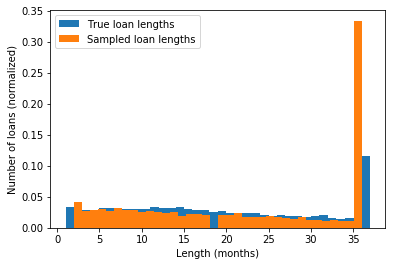

Average length of sampled loans: 21.96 months
Average length of true loans: 18.17 months


In [13]:
plot_sampled_lengths(sampled_trajectories, df)

## Experiment 2: Stationary Markov Chain without Priors

### 2.1 Model

In [26]:
x, T = build_mc_no_priors(n_states, chain_len)

### 2.2 Inference

In [27]:
inferred_T, sess, T, qx = infer_mc_no_priors(x_train, x, T, n_states, chain_len)

Loading experiment2 data from cache...
Loading cached edward model...
Retrieved 8 rows, 8 columns in 0.19 seconds


In [28]:
inferred_T

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.151815,0.144816,0.147415,0.148537,0.153261,0.149700,0.153957,0.145684
Current,0.139258,0.137716,0.145338,0.141780,0.143332,0.137446,0.140408,0.142527
Default,0.124740,0.123742,0.120178,0.116529,0.112392,0.113944,0.119907,0.116578
Fully Paid,0.113481,0.110451,0.111394,0.110592,0.109300,0.113793,0.106898,0.111895
In Grace Period,0.121316,0.121332,0.130171,0.127002,0.126071,0.129887,0.127170,0.127645
Issued,0.119581,0.119551,0.114546,0.122284,0.120460,0.116047,0.121440,0.120053
Late (16-30 days),0.112322,0.111935,0.115255,0.115667,0.114750,0.121577,0.109608,0.114562
Late (31-120 days),0.117486,0.130457,0.115703,0.117609,0.120433,0.117605,0.120612,0.121055


### 2.3 Criticism

@Basil: now that we have the sess, we can access values in this session by using with sess.as_default().

In [29]:
# sampling new states:
with sess.as_default():
    print(sess.run(qx[0].sample()))

5


In [30]:
with sess.as_default():
    print(sess.run(qx[10].probs))

[0.13561748 0.1288847  0.12656064 0.1070434  0.10686985 0.12603015
 0.14928031 0.11971346]


In [31]:
with sess.as_default():
    print(sess.run(T))

[[0.15181515 0.14481598 0.1474153  0.14853749 0.15326086 0.1497001
  0.15395734 0.14568399]
 [0.13925791 0.13771576 0.14533757 0.14177966 0.1433319  0.13744645
  0.14040788 0.14252698]
 [0.12474017 0.12374203 0.12017793 0.11652918 0.11239248 0.11394449
  0.11990742 0.11657769]
 [0.1134811  0.11045069 0.11139417 0.11059228 0.10930025 0.11379327
  0.10689771 0.11189532]
 [0.12131648 0.12133186 0.13017137 0.12700196 0.12607129 0.12988727
  0.12716967 0.12764537]
 [0.11958117 0.11955133 0.11454625 0.12228364 0.12046002 0.11604656
  0.1214401  0.12005339]
 [0.11232159 0.11193538 0.11525464 0.11566687 0.11475012 0.12157657
  0.10960769 0.11456244]
 [0.11748645 0.13045697 0.11570276 0.11760893 0.12043307 0.11760526
  0.12061224 0.12105472]]


## Experiment 3: Stationary Markov Chain with Priors

### 3.1 Model

The first Bayesian model we built uses the Categorical Distribution to model state transitions, with the Dirichlet Distribution as priors. 

Recall the Categorical Distribution, denoted Cat$(p_1, ..., p_K)$, is a generalization of the Bernoulli Distribution across outcome states, namely, it describes the possible results of a single trial random variable $X$ that can take on one of $K$ possible outcome states, with the probability of each category given by $(p_1, ..., p_K)$. Recall in our scenario, $K=8$ representing the possible `loan_status` states. The probability mass function is then given by:

$$
\begin{align*}
p(X=x | p_1, ..., p_K) = \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x = j)}
\end{align*}
$$

The Dirichlet Distribution, denoted Dir$(a_1, ..., a_K)$, is the conjugate prior of the Categorical Distribution. It describes the probabilities for a K-dimensional vector of random variables $\bar{x}$ with entries in (0,1) and which sum to 1. It should be clear why this makes sense for modelling our Categorical priors. It is parameterixed by $(a_1, ..., a_K)$, called the concentration paramters, which become hyperparameters in our model. The probability density function is given by:

$$
\begin{align*}
p(\bar{X}=[x_1, ..., x_K] | a_1, ..., a_K) = \frac{\Gamma(\sum_{i=1}^K a_i)}{\prod_{i=1}^K \Gamma(a_i)}\prod_{i=1}^K x_i^{a_i - 1}
\end{align*}
$$

[Tu, 2018](#References)

The Markov Chain model we specify for transition matrix $A$, outcome states $K=8$ over sequence of months $T=36$ is given by:

$$
\begin{align*}
x_t \text{ ~ Cat}_{(j, t-1)}(p_1, ..., p_K) \space\space\space\space t \in T, \space\space j \in K
\end{align*}
$$



In [20]:
batch_size = 1000

In [35]:
x, pi_0, pi_T = build_mc_with_priors(n_states, chain_len, batch_size)

### 3.2 Inference (Batch)

In [36]:
df, sess, qpi_0, qpi_t = infer_mc_with_priors(x_train, x, pi_0, pi_T, n_states, chain_len, batch_size)

Loading experiment3 data from cache...
Loading cached edward model...
Retrieved 8 rows, 8 columns in 0.08 seconds


In [37]:
df

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.270607,0.128769,0.081541,0.070428,0.076399,0.117405,0.164460,0.090392
Current,0.015246,0.828056,0.021040,0.044684,0.022390,0.016792,0.030016,0.021775
Default,0.152546,0.120394,0.123971,0.131847,0.155846,0.082085,0.145534,0.087778
Fully Paid,0.036865,0.050035,0.050240,0.638405,0.036351,0.063181,0.046973,0.077950
In Grace Period,0.158774,0.121978,0.118425,0.112937,0.076360,0.117436,0.174530,0.119560
Issued,0.116244,0.172275,0.102518,0.079343,0.177434,0.169137,0.112600,0.070449
Late (16-30 days),0.112473,0.155421,0.105290,0.164747,0.076349,0.166576,0.115024,0.104120
Late (31-120 days),0.175590,0.130657,0.103344,0.155574,0.132815,0.059216,0.153257,0.089548


In [38]:
with sess.as_default():
    print(sess.run(qpi_0))
    print(sess.run(qpi_t))

[0.10474963 0.08141562 0.23531985 0.02791097 0.03937913 0.08043075
 0.16235298 0.26844108]
[[3.82505059e-01 2.28392497e-01 1.01010688e-01 2.37050059e-04
  3.60750370e-02 1.25232721e-02 1.52996823e-01 8.62595811e-02]
 [2.70558492e-04 6.90671027e-01 3.71852964e-02 6.03663782e-03
  2.69318577e-02 1.01684756e-03 1.74833387e-01 6.30544052e-02]
 [2.50895202e-01 2.90051196e-02 1.68283030e-01 2.04329908e-01
  1.41963422e-01 1.33138569e-02 9.91984084e-02 9.30110961e-02]
 [1.39018968e-01 3.48017588e-02 2.27025554e-01 4.49428588e-01
  1.05724540e-02 1.07159406e-01 1.62299108e-02 1.57633424e-02]
 [3.96116823e-01 2.51729768e-02 1.75964862e-01 1.01234242e-01
  8.31274502e-03 1.43382728e-01 4.65528406e-02 1.03262752e-01]
 [2.25536197e-01 2.80080903e-02 2.60042906e-01 1.10142626e-01
  1.84442624e-01 7.83376992e-02 7.01918527e-02 4.32980508e-02]
 [4.28195149e-01 1.54667854e-01 2.48399004e-03 8.25597048e-02
  1.87181860e-01 3.76919955e-02 9.46681350e-02 1.25512350e-02]
 [1.34759769e-01 2.55508691e-01 5.

### 3.3 Criticism

## References

*Machine Learning: A Probabilistic Perspective*, by Kevin P. Murphy, MIT Press, 2012.

*The Dirichlet-Multinomial and Dirichlet-Categorical models for Bayesian inference*, by Stephen Tu, retrieved from https://people.eecs.berkeley.edu/~stephentu/writeups/dirichlet-conjugate-prior.pdf